In [1]:
# Imports
import os
import datetime

import torch
from torch.utils.data import TensorDataset, Dataset
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, FloatType, StringType
from pyspark.sql.window import Window
import pyspark.sql.functions as F
from pyspark.pandas.frame import DataFrame
import pyspark.pandas as ps

# Import utils
from utils import get_global_config, build_spark_session, train, evaluate

# Always import wfdb last because it might break jupyter
import wfdb

# Initial setup
cfg = get_global_config()
# spark = build_spark_session()

/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/pyspark/pandas/__init__.py:49: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [2]:
# Defining paths for local
# DATAPATH = '/Users/michaelscott/bd4h/project/data' 
# MIMICPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-1.4'
# DEMOPATH = DATAPATH + '/mimic3/mimic-iii-clinical-database-demo-1.4'
# WAVEFPATH = DATAPATH + '/waveform/physionet.org/files/mimic3wdb-matched/1.0'
# OUTPUTPATH = './output'

# function for creating datasets
def create_batch(df, window_size=cfg['WINDOWSIZE'], overlap_pct=cfg['RECORDOVERLAP']):
	# Convert to numpy array of 120 rows each
	# with intersect of 40%
	# Set the window size to 120 and the overlap to 40%
	overlap = int(window_size * overlap_pct)

	# Convert the DataFrame to a numpy array
	data = df.values

	if len(data) == window_size:
		# Convert the list of windows to a numpy array
		# Create a new axis to to specify batch size of 1
		windows = np.array(data)[np.newaxis, :]

	else:
		# Use the rolling method to create the sliding windows
		windows = []
		for i in range(0, len(data) - window_size, window_size - overlap):
			window = data[i:i+window_size]
			windows.append(window)
		
		# Convert the list of windows to a numpy array
		windows = np.array(windows)
		
	# converts from (n, 120, 10) to (n, 10, 120) 
	return np.swapaxes(windows,1,2)

def get_arr(arr, y):
	return np.array([y]*arr.shape[0]).squeeze()

def load_dataset(x,age_arr,y):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x).type(torch.FloatTensor)
	target = torch.from_numpy(y).type(torch.FloatTensor) # BCE with logit expects target to be float. CrossEntropy expects long
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float(), target.float())

	return dataset

# Functions for waveform
def get_waveform_path(record_name):
	patient_id = record_name[0:7]
	return cfg['WAVEFPATH'] + f'/{patient_id[0:3]}/{patient_id}/{record_name}'

def plot_waveform(ca_time_str = '2104-12-05 08:40:00', record_name = 'p087675-2104-12-05-03-53n'):
	# Get waveform data
	patient_path = get_waveform_path(record_name)
	record = wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

	# Select only HR from the plots, not with the channels parameter
	fig = wfdb.plot_wfdb(record=record, title=record_name[0:7], figsize=(10,15), return_fig=True)
	ax_list = fig.axes

	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])

	# Create datetime using strptime
	ca_time = datetime.datetime.strptime(ca_time_str, '%Y-%m-%d %H:%M:%S')

	# find time delta between base_time and ca_time
	# Convert it to an int that represents the number of seconds
	time_delta = int((ca_time - base_time).total_seconds())

	# Plot a vertical line at time_delta
	if time_delta > 0:
		for ax in ax_list:
			ax.axvline(x=time_delta, color='red', linestyle='--',)
	else:
		# change title of fig
		fig.suptitle('Cardiac Arrest Time is before the start of the recording')

	fig.show()

	display(record.__dict__)

def get_base_time(record_name):
	basetime = record_name[8:]
	basetime = basetime.strip().strip('n')
	return basetime

def get_record(record_name):
	patient_path = get_waveform_path(record_name)
	return wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])

def get_ending_time(record_name):
	"""Ending time is the end time of a record"""
	# Get waveform data
	record = get_record(record_name)
	
	# get time when recording started
	base_time = datetime.datetime.combine(record.__dict__['base_date'], 
							record.__dict__['base_time'])
	
	duration = record.__dict__['sig_len'] * (1/record.__dict__['fs']) 

	# Add duration to base time
	end_time = base_time + datetime.timedelta(seconds=duration)

	record_present = [0 for i in range(len(cfg['CHANNEL_NAMES']))]

	# One hot encode the presence of signals
	for idx, val in enumerate(cfg['CHANNEL_NAMES']):
		if val in record.__dict__['sig_name']:
			record_present[idx] = 1

	return end_time, record_present

""" Model"""
class MyCNN(nn.Module):
	def __init__(self):
		# self.MAGIC_NUMBER = 16*41
		super(MyCNN, self).__init__()
		self.conv1 = nn.Conv1d(in_channels=10, out_channels=4, kernel_size=5)
		self.conv2 = nn.Conv1d(in_channels=4, out_channels=1, kernel_size=5)
		self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
		# self.out = nn.Linear(in_features=567, out_features=1)

		self.dropout = nn.Dropout(0.5)
		self.lstm = nn.LSTM(input_size = 27, hidden_size=16, num_layers=2)
		self.out = nn.Linear(in_features=16, out_features=1, bias=True)

		self.age_fn = nn.Linear(in_features=1, out_features=1, bias=True)

	def forward(self, x, age):
		x = torch.tanh(self.conv1(x))
		x = self.pool(x)
		x = torch.tanh(self.conv2(x))
		x = self.pool(x)
		x = self.dropout(x)
		x = x.view(-1, 27)
		x,_ = self.lstm(x)
		x = torch.sigmoid(self.out(x))
		# print(age.shape)
		# If age is a scalar, we need to retrieve the item before unsqueezing it
		# if age.shape == torch.Size([1]):
		# 	## Convert x from size ([]) to ([batchsize])
		# 	# age = age.item()
		# 	# age = torch.tensor([age], requires_grad=True)
		# 	# age.unsqueeze_(0)
		# 	# age.requires_grad_(True) 
		# 	age_scale = self.age_fn(age.unsqueeze(0))
		# 	x = (x*age_scale).squeeze(0) # squeeze only the first dimension that is 1
			
		# 	# print(x)
		# 	# print(x.shape)
		# else:
		# 	# works for batch size > 1
		# 	age_scale = self.age_fn(age.unsqueeze(1))
		# 	x = (x*age_scale).squeeze() # squeeze all dimensions that is 1
		# 	# print(x)
		# 	# print(x.shape)
		age_scale = self.age_fn(age.unsqueeze(1)) # add an additional dimension
		x = (x*age_scale).squeeze(1) # squeeze 
		# print(x)
		# print(x.shape)
		return x

# Lesson on why you need age.unsqueeze(1):
# The error is most likely caused by the fact that age is a tensor of shape (32,),
#  which means it has 32 elements but is not a matrix. However, self.age_fn is a linear layer 
# that expects a matrix as input. Specifically, the in_features parameter is set to 1, which means 
# it expects a matrix of size (batch_size, 1).

# When you pass age to self.age_fn, it is implicitly expanded to a matrix of size (batch_size, 32)
#  by adding a singleton dimension at the end (since age has size (32,)), which is not what you want. 
# Instead, you should first unsqueeze the tensor along the second dimension (i.e., age.unsqueeze(1)) 
# to get a matrix of size (batch_size, 1), and then pass it to self.age_fn.

In [3]:
# Use patient 70723 as an example

# Information needed
# - SUBJECTID
# - STARTTIME (Cardiac arrest time)
# - RECORDNAME
# - BASETIME
# - ENDTIME 
# - Age

# We assume that all these information are conveninently stored in a table for us, 
# and we will start from there. Here, we define them as constants.
# Later we will move them to a table and read from there.

# Defining constants
SUBJECTID = 70723
RECORDNAME = 'p070723-2163-11-18-16-28n'
BASETIME = get_base_time(RECORDNAME)
ENDTIME, RECORD_PRESENT = get_ending_time(RECORDNAME)
CATIME = datetime.datetime.strptime('2163-11-20 11:37:20', '%Y-%m-%d %H:%M:%S') # ORIGINALLY 2163-11-18 15:06:00 (TIME OF NOTEEVENTS)
SPLITTIME = CATIME - datetime.timedelta(hours=2)
FINISHTIME = SPLITTIME - datetime.timedelta(minutes=5)
AGE = 60

/var/folders/lc/wjv2l4cd19s4276v_sgzt_q40000gn/T/ipykernel_11095/1881541489.py:93: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


{'record_name': 'p070723-2163-11-18-16-28n',
 'n_sig': 5,
 'fs': 1,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 158241,
 'base_time': datetime.time(16, 28, 34),
 'base_date': datetime.date(2163, 11, 18),
 'comments': ['Location: micu/sicu'],
 'sig_name': ['HR', 'RESP', 'PULSE', 'SpO2', 'CVP'],
 'p_signal': array([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat',
  '3476173n.dat'],
 'fmt': ['16', '16', '16', '16', '16'],
 'samps_per_frame': [1, 1, 1, 1, 1],
 'skew': [None, None, None, None, None],
 'byte_offset': [None, None, None, None, None],
 'adc_gain': [1.0, 1.0, 1.0, 1.0, 1.0],
 'baseline': [0, 0, 0, 0, 0],
 'units': ['bpm', 'pm', 'bpm', '%', 'mmHg'],
 'adc_re

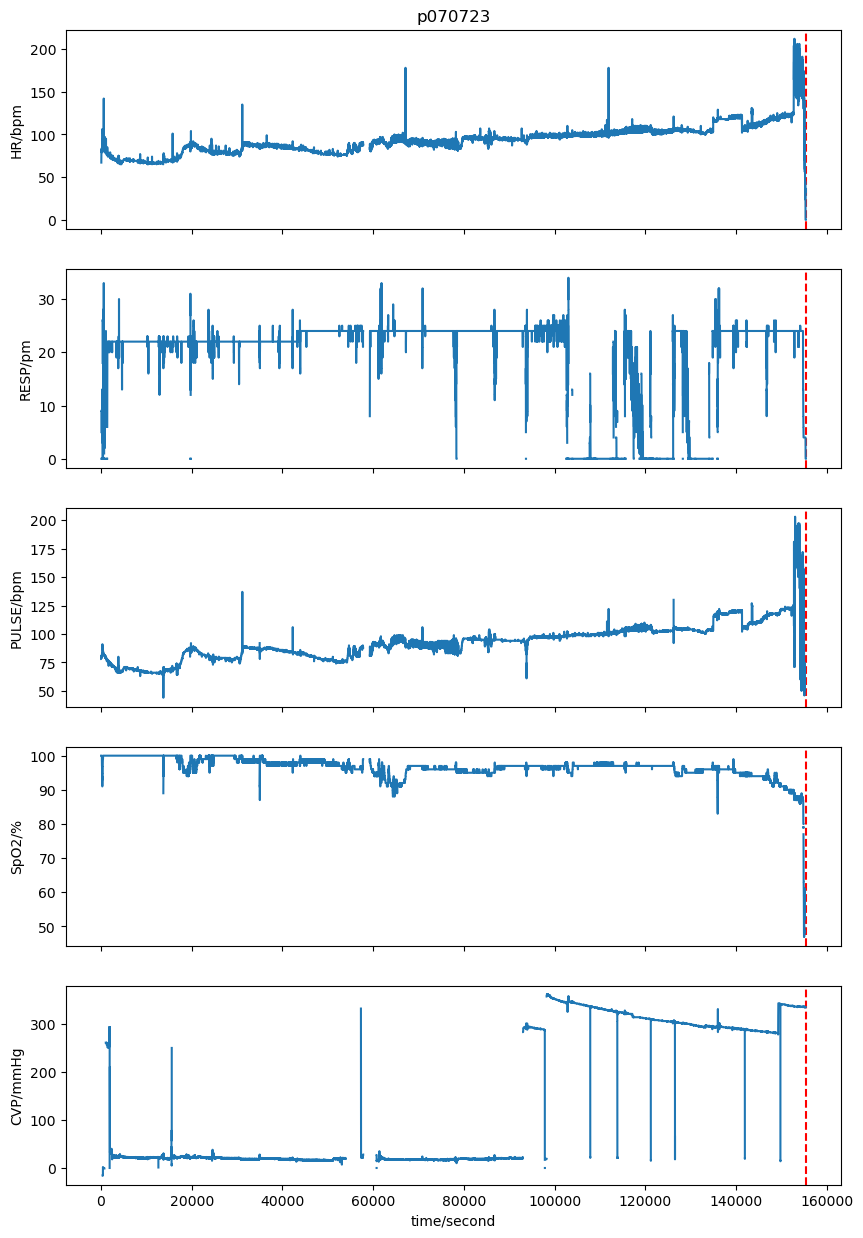

In [4]:
plot_waveform(ca_time_str = CATIME.strftime('%Y-%m-%d %H:%M:%S'), record_name = RECORDNAME)

In [5]:
# Retrieve record
record = get_record(RECORDNAME)
record_df = record.to_dataframe()

# get the index of the first non-null value in the DataFrame
actual_BASETIME = record_df.first_valid_index()

# get actual CA time as the final valid index of the entire dataframe
# if the patient is dead
actual_CATIME = record_df.last_valid_index()

# get actual splittime
actual_SPLITTIME = actual_CATIME - datetime.timedelta(hours=2)

actual_FINISHTIME = actual_CATIME - datetime.timedelta(minutes=5)

# retrieve the first non-null record using the loc method
record_df = record_df.loc[actual_BASETIME:actual_CATIME]

for channel in cfg['CHANNEL_NAMES']:
    if channel not in record_df.columns:
        record_df[channel.replace(' ','_')] = 0

# perform preprocessing
record_df = record_df.interpolate(method='linear').fillna(0)

# Sample at 5 second interval
# take instantaneous value
record_df = record_df.resample('5S').first()

# can also consider this alternative:
# record_df = record_df.resample('5S').mean()

# Split into two parts:
# 1. Long before cardiac arrest (anytime - 2hours before STARTTIME)
# 2. Immediately before cardiac arrest (2 hours - 5 minutes before STARTTIME)
# record_df['y'] = 0 
# record_df.loc[:actual_SPLITTIME,'y'] = 0
# record_df.loc[actual_SPLITTIME:actual_FINISHTIME,'y']=1

# Drop the remaninig records (last 5 minutes before cardiac arrest)
# Though we can consider it as +ve sample actually if we lack training data
# record_df = record_df.loc[:actual_FINISHTIME]

# define positive and negative
negative_df = record_df.loc[:actual_SPLITTIME]
positive_df = record_df.loc[actual_SPLITTIME:actual_FINISHTIME,:]

In [6]:
actual_BASETIME

Timestamp('2163-11-18 16:29:03', freq='S')

In [7]:
positive_df

,HR,RESP,PULSE,SpO2,CVP,etco2,AWRR,NBP_Mean,NBP_Dias,NBP_Sys
2163-11-20 09:37:20,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:25,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:30,117.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:35,119.0,24.0,118.0,92.0,281.0,0,0,0,0,0
2163-11-20 09:37:40,119.0,24.0,118.0,92.0,282.0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2163-11-20 11:32:00,139.0,4.0,58.0,48.0,336.0,0,0,0,0,0
2163-11-20 11:32:05,121.0,4.0,57.0,49.0,336.0,0,0,0,0,0
2163-11-20 11:32:10,117.0,4.0,53.0,49.0,336.0,0,0,0,0,0
2163-11-20 11:32:15,121.0,4.0,51.0,53.0,336.0,0,0,0,0,0


In [8]:
# Create x, y, and a arr for negative
x_negative_arr = create_batch(negative_df)
y_negative_arr = get_arr(x_negative_arr,0)
a_negative_arr = get_arr(x_negative_arr,AGE)

# Create x, y, and a arr for positive
x_positive_arr = create_batch(positive_df)
y_positive_arr = get_arr(x_positive_arr,1)
a_positive_arr = get_arr(x_positive_arr,AGE)

# Concatenating all arrays
x_arr = np.concatenate([x_negative_arr,x_positive_arr])
y_arr = np.concatenate([y_negative_arr,y_positive_arr])
a_arr = np.concatenate([a_negative_arr,a_positive_arr])

# converts from (n, 120, 10) to (n, 10, 120) 
# x_arr = np.swapaxes(x_arr,1,2)

# Split between train + test
from sklearn.model_selection import ShuffleSplit # or StratifiedShuffleSplit
sss = ShuffleSplit(n_splits=1, test_size=0.3)
sss.get_n_splits(x_arr, y_arr)
train_index, valtest_index = next(sss.split(x_arr, y_arr)) 

X_train, X_valtest = x_arr[train_index], x_arr[valtest_index] 
a_train, a_valtest = a_arr[train_index], a_arr[valtest_index] 
y_train, y_valtest = y_arr[train_index], y_arr[valtest_index]

# Split between val and test
sss = ShuffleSplit(n_splits=1, test_size=0.5)
sss.get_n_splits(X_valtest, y_valtest)
val_index, test_index = next(sss.split(X_valtest, y_valtest)) 

X_val, X_test = X_valtest[val_index], X_valtest[test_index] 
a_val, a_test = a_valtest[val_index], a_valtest[test_index] 
y_val, y_test = y_valtest[val_index], y_valtest[test_index]

# Create dataloader
dataset = load_dataset(x_arr, a_arr, y_arr)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, drop_last=True)

# Print the data out
# for i, (input, age, target) in enumerate(data_loader):
#     print(input,age,target)

In [9]:
pd.DataFrame(X_test[0].T)

,0,1,2,3,4,5,6,7,8,9
0,95.0,24.0,97.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
1,96.0,24.0,97.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
2,96.0,24.0,96.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
3,96.0,24.0,95.0,95.0,18.0,0.0,0.0,0.0,0.0,0.0
4,96.0,24.0,96.0,95.0,18.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
115,95.0,24.0,95.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
116,95.0,24.0,95.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
117,95.0,24.0,95.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0
118,96.0,24.0,95.0,95.0,19.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data_df = pd.DataFrame(X_test[0].T)

In [11]:
# Creating a mock x test file
data_df.to_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT',index=False)

In [48]:
# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
PATH_OUTPUT = "../model/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 100
BATCH_SIZE = 16
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN5.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

train_dataset = load_dataset(X_train, a_train, y_train)
valid_dataset = load_dataset(X_val,   a_val,   y_val)
test_dataset  = load_dataset(X_test,  a_test,  y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, cfg['MODELPATH'], _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(cfg['MODELPATH'])
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)


Model Summary: 5300
Epoch: [0][0/19]	Time 0.011 (0.011)	Data 0.002 (0.002)	Loss 0.0000 (0.0000)	Accuracy 100.000 (100.000)
Epoch: [0][10/19]	Time 0.003 (0.005)	Data 0.000 (0.001)	Loss 1.0459 (0.7721)	Accuracy 93.750 (95.455)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0000 (0.0000)	Accuracy 100.000 (100.000)
Epoch: [1][0/19]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.0000 (0.0000)	Accuracy 100.000 (100.000)
Epoch: [1][10/19]	Time 0.004 (0.004)	Data 0.000 (0.000)	Loss 0.0000 (0.6109)	Accuracy 100.000 (96.023)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0000 (0.0000)	Accuracy 100.000 (100.000)
Epoch: [2][0/19]	Time 0.006 (0.006)	Data 0.000 (0.000)	Loss 0.0000 (0.0000)	Accuracy 100.000 (100.000)


/Users/michaelscott/opt/anaconda3/envs/bd4hproject/lib/python3.9/site-packages/torch/serialization.py:474: UserWarning: Couldn't retrieve source code for container of type MyCNN. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


Epoch: [2][10/19]	Time 0.004 (0.004)	Data 0.000 (0.000)	Loss 1.5508 (0.4982)	Accuracy 87.500 (96.023)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0001 (0.0001)	Accuracy 100.000 (100.000)
Epoch: [3][0/19]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.6042 (0.6042)	Accuracy 93.750 (93.750)
Epoch: [3][10/19]	Time 0.004 (0.003)	Data 0.000 (0.000)	Loss 0.4925 (0.2996)	Accuracy 93.750 (96.591)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0016 (0.0016)	Accuracy 100.000 (100.000)
Epoch: [4][0/19]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.3814 (0.3814)	Accuracy 93.750 (93.750)
Epoch: [4][10/19]	Time 0.003 (0.003)	Data 0.000 (0.000)	Loss 0.0056 (0.3660)	Accuracy 100.000 (94.886)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0135 (0.0135)	Accuracy 100.000 (100.000)
Epoch: [5][0/19]	Time 0.005 (0.005)	Data 0.000 (0.000)	Loss 0.2687 (0.2687)	Accuracy 93.750 (93.750)
Epoch: [5][10/19]	Time 0.003 (0.004)	Data 0.000 (0.000)	Loss 0.0238 (0.1869)	Accuracy 100.000 (96.023)
Test: [0/4]	Time 0.001 (0.001)	Loss 0.0347 (0.0347

In [49]:
for i in test_loader:
    print(i)
    break

[tensor([[[ 95.,  96.,  96.,  ...,  95.,  96.,  95.],
         [ 24.,  24.,  24.,  ...,  24.,  24.,  24.],
         [ 97.,  97.,  96.,  ...,  95.,  95.,  95.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[100., 100., 100.,  ..., 100., 100.,  99.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [ 99., 100., 100.,  ...,  99., 100., 101.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]],

        [[102., 102., 102.,  ..., 101., 101., 101.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [102., 102., 102.,  ..., 101., 101., 101.],
         ...,
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.],
         [  0.,   0.,   0.,  ...,   0.,   0.,   0.]]

In [50]:
test_results

[(0.0, 0, 4.850585355598014e-08),
 (0.0, 0, 6.512265571245734e-08),
 (0.0, 0, 8.436053633431584e-08),
 (0.0, 0, 9.532117672961249e-08),
 (0.0, 0, 1.0105959091788463e-07),
 (0.0, 0, 1.1092409124557889e-07),
 (0.0, 0, 1.1270572031207848e-07),
 (0.0, 0, 1.1951907197271794e-07),
 (0.0, 0, 1.1847208725157543e-07),
 (0.0, 0, 1.155893656346052e-07),
 (0.0, 0, 1.2042431762893102e-07),
 (0.0, 0, 1.1859993520602075e-07),
 (0.0, 0, 1.1546399036888033e-07),
 (1.0, 0, 1.2021534701034398e-07),
 (0.0, 0, 1.2036001351134473e-07),
 (0.0, 0, 1.1730275417676239e-07),
 (0.0, 0, 4.850585355598014e-08),
 (0.0, 0, 6.512265571245734e-08),
 (0.0, 0, 7.882803743086697e-08),
 (0.0, 0, 8.871381140806989e-08),
 (0.0, 0, 1.0171437736516964e-07),
 (0.0, 0, 1.065425010438048e-07),
 (0.0, 0, 1.0786975934706788e-07),
 (0.0, 0, 1.1512357644960503e-07),
 (1.0, 0, 1.2313309127875982e-07),
 (0.0, 0, 1.2162905704826699e-07),
 (0.0, 0, 1.2617722688901267e-07),
 (0.0, 0, 1.2297853402287728e-07),
 (0.0, 0, 1.1856329962256495e-

In [17]:
[idx if val == 1 for idx,val in enumerate(y_test)]

SyntaxError: invalid syntax (554081738.py, line 1)

In [51]:
print(test_results)

[(0.0, 0, 4.850585355598014e-08), (0.0, 0, 6.512265571245734e-08), (0.0, 0, 8.436053633431584e-08), (0.0, 0, 9.532117672961249e-08), (0.0, 0, 1.0105959091788463e-07), (0.0, 0, 1.1092409124557889e-07), (0.0, 0, 1.1270572031207848e-07), (0.0, 0, 1.1951907197271794e-07), (0.0, 0, 1.1847208725157543e-07), (0.0, 0, 1.155893656346052e-07), (0.0, 0, 1.2042431762893102e-07), (0.0, 0, 1.1859993520602075e-07), (0.0, 0, 1.1546399036888033e-07), (1.0, 0, 1.2021534701034398e-07), (0.0, 0, 1.2036001351134473e-07), (0.0, 0, 1.1730275417676239e-07), (0.0, 0, 4.850585355598014e-08), (0.0, 0, 6.512265571245734e-08), (0.0, 0, 7.882803743086697e-08), (0.0, 0, 8.871381140806989e-08), (0.0, 0, 1.0171437736516964e-07), (0.0, 0, 1.065425010438048e-07), (0.0, 0, 1.0786975934706788e-07), (0.0, 0, 1.1512357644960503e-07), (1.0, 0, 1.2313309127875982e-07), (0.0, 0, 1.2162905704826699e-07), (0.0, 0, 1.2617722688901267e-07), (0.0, 0, 1.2297853402287728e-07), (0.0, 0, 1.1856329962256495e-07), (0.0, 0, 1.147676300661

That was for training the model. Now, we expect the model to take in some input. How will the input be?

In [37]:

def load_dataset_production(x_arr, age_arr):
	"""
	:param path: a path to the seizure data CSV file
	:return dataset: a TensorDataset consists of a data Tensor and a target Tensor
	"""
	# Casting in pytorch tensor
	data = torch.from_numpy(x_arr).type(torch.FloatTensor)
	age = torch.from_numpy(age_arr).type(torch.FloatTensor)

	# x[torch.isnan(x)] = 0

	# Need to be of size (N, Cn, L)
	# N: batch size
	# Cn: number of channels
	# L: length of the sequence
	# data = data.reshape((data.shape[0], data.shape[1], data.shape[2]))
	dataset = TensorDataset(data, age.float())

	return dataset


In [27]:
x_arr

tensor([[[95., 96., 96.,  ..., 95., 96., 95.],
         [24., 24., 24.,  ..., 24., 24., 24.],
         [97., 97., 96.,  ..., 95., 95., 95.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]]])

In [52]:
cfg['MODELPATH'] = '../model/MyCNN5.pth'

# Loading the model
model = torch.load(cfg['MODELPATH'])

model.eval()

# Assume that data_df comes in as a pandas dataframe
data_df = pd.read_csv(cfg['EXPLOREPATH']+'/X.TESTINPUT')

# Generate an feature array
x_arr = create_batch(data_df, window_size=cfg['WINDOWSIZE'], overlap_pct = 0)

# converts from (n, 120, 10) to (n, 10, 120) 
print(x_arr.shape)
# x_arr = np.swapaxes(x_arr,1,2)

# generate an age array of the same size as x_arr
a_arr = get_arr(x_arr,AGE)

with torch.no_grad():
	x_arr = torch.from_numpy(x_arr).type(torch.FloatTensor).to(device).float()
	a_arr = torch.from_numpy(a_arr).type(torch.FloatTensor).unsqueeze(0).to(device).float()
	output = model(x_arr, a_arr)
	x_arr=x_arr.to(device)
	a_arr=a_arr.to(device)
	y = torch.sigmoid(output).detach().to('cpu')
	y_pred = y.round().long().numpy().tolist()
	y_prob = y.numpy().tolist()

	print(y_prob)
	print(y_pred)
# Prove that this is the same results as the evaluation set 

(1, 10, 120)
[4.850585355598014e-08]
[0]


In [43]:
1/(1+np.exp(7.772055710120185e-07))

0.49999980569860725

In [35]:
prod_dataloader

In [191]:
a_arr.shape

torch.Size([])

In [189]:
x_arr.shape

torch.Size([1, 10, 120])

In [184]:
TensorDataset(torch.from_numpy(x_arr).type(torch.FloatTensor),\
              torch.from_numpy(a_arr).type(torch.FloatTensor).float())

IndexError: Dimension specified as 0 but tensor has no dimensions

Finding a way of uploading the age to "patients" in dataframe

pd.read_csv()

tensor(60.)

In [47]:
torch.tensor([age.item()]).unsqueeze(1)

tensor([[60.]])

In [ ]:
# bookmark

# Older method (Not relevant anymore)

In [ ]:
subject_id = 44083
# read this using datetime.datetime
cur_time = '2112-05-04-19-50'
# extract date from string
from datetime import datetime

date_str = '2112-05-04-19-50'
format_str = '%Y-%m-%d-%H-%M'

# Use format string '%Y-%m-%d-%H-%M' to create a datetime.datetime object
dt = datetime.strptime(date_str, format_str)

# Convert datetime.datetime to numpy.datetime64
waveform_date = np.datetime64(dt)

# Get patient age
patients_df = ps.read_csv(f'{cfg["MIMICPATH"]}/PATIENTS.csv.gz', usecols = ['SUBJECT_ID','DOB'])
bday = patients_df.query("SUBJECT_ID==44083")['DOB']
birthday_date = bday.values[0]

time_diff = np.timedelta64(waveform_date - birthday_date, 's')
age = time_diff.astype('float') / (3600 * 24 * 365.25)

# EXTRACT
# Calculate 

In [ ]:
# This is a patient with cardiac arrest

patient_path = get_waveform_path('p044083-2112-05-04-19-50n')

# select only HR from patient path using wfdb
record = wfdb.rdrecord(patient_path, channel_names=cfg['CHANNEL_NAMES'])
# record = wfdb.rdrecord(patient_path) 

# wfdb.plot_wfdb(record=record, title='Record  029299') 
# increase the size of the plot please
# wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15))

# Select only HR from the plots, not with the channels parameter
fig = wfdb.plot_wfdb(record=record, title='Record  029299', figsize=(10,15), return_fig=True)
ax_list = fig.axes

import datetime 

base_time = datetime.datetime.combine(record.__dict__['base_date'], 
                          record.__dict__['base_time'])

# Create datetime using strptime
ca_time = datetime.datetime.strptime('2112-05-04 04:38:00', '%Y-%m-%d %H:%M:%S')

# find time delta between base_time and ca_time
# Convert it to an int that represents the number of seconds
time_delta = int((ca_time - base_time).total_seconds())

# Plot a vertical line at time_delta
if time_delta > 0:
    for ax in ax_list:
        ax.axvline(x=time_delta, color='red', linestyle='--',)
else:
    # change title of fig
    fig.suptitle('Cardiac Arrest Time is before the start of the recording')

fig.show()

display(record.__dict__)

In [7]:
record_df = record.to_dataframe()
record_df = record_df.interpolate(method='linear').fillna(0)

# We take ten minutes of data with 1 minute of sliding window
record_df = record_df.iloc[::5, :]

# Which means that each should have 120 records
record_arr = np.stack([record_df.iloc[i:i+int(600/5), :].values for i in range(0, len(record_df)-int(600/5), int(60/5))])
record_arr.shape

(2739, 120, 7)

In [8]:
record_arr = record_arr.reshape(2739, 7, 120)
record_arr

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,  82.        ],
        [  0.        ,  81.        , 100.        , ...,   0.        ,
          82.        ,   6.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  81.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,  81.        ,
          94.63741339,   0.        ],
        [  0.        ,   0.        ,  81.        , ...,  89.33718245,
           0.        ,   0.        ],
        [  0.        ,  82.        ,  10.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,  80.        , ...,   0.        ,
           0.        ,  82.        ],
        [  4.2       ,  81.        , 100.        , ...,   0.        ,
          81.        ,  11.        ],
        [ 81.        , 100.        ,   0.        , ...,  81.        ,
          11.        ,  80.        ],
        ...,


In [9]:
x = record_arr
record_df['y']=1
y = record_df['y'].astype(np.float32).values
y = np.random.randint(low=0, high=2, size=record_arr.shape[0]).squeeze()
age_arr = np.random.randint(30, 60, size=record_arr.shape[0]).squeeze() * 1.0
# y = torch.randint(2, size=(record_arr.shape[0],))
y.shape

(2739,)

In [10]:
age_arr.shape

(2739,)

In [11]:
x.shape

(2739, 7, 120)

In [13]:
dataset = load_dataset(x,age_arr,y)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0)
for i, (input, age, target) in enumerate(data_loader):
    print(input,age,target)

tensor([[[ 81.0000,  14.0000,  80.0000,  ...,   0.0000,   0.0000,  82.0000],
         [ 14.0000,  81.0000,  99.0000,  ...,   0.0000,  81.0000,  13.0000],
         [ 81.0000,  99.0000,   0.0000,  ...,  81.0000,  16.0000,  84.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,  82.0000,  99.0000,   0.0000],
         [  0.0000,   0.0000,  82.0000,  ...,  99.0000,   0.0000,   0.0000],
         [  0.0000,  82.0000,  14.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ 91.0000,  16.0000,  90.0000,  ...,   0.0000,   0.0000,  89.0000],
         [ 16.0000,  89.0000,  98.0000,  ...,   0.0000,  90.0000,  16.0000],
         [ 89.0000,  94.0000,   0.0000,  ...,  90.0000,  16.0000,  97.0000],
         ...,
         [  0.0000,   0.0000,   0.0000,  ...,  90.3529,  96.9412,   0.0000],
         [  0.0000,   0.0000,  91.0000,  ...,  98.0000,   0.0000,   0.0000],
         [  0.0000,  94.0000,  13.0000,  ...,   0.0000,   0.0000,   0.0000]],

        [[ 87.0000,  15.0000,  86.0000,  ...

In [15]:
age_arr.shape

(2739,)

In [21]:

# from plots import plot_learning_curves, plot_confusion_matrix

#TODO: https://pytorch.org/docs/stable/notes/windows.html#multiprocessing-error-without-if-clause-protection

# # Set a correct path to the seizure data file you downloaded
# PATH_TRAIN_FILE = "../data/seizure/seizure_train.csv"
# PATH_VALID_FILE = "../data/seizure/seizure_validation.csv"
# PATH_TEST_FILE = "../data/seizure/seizure_test.csv"

# # Path for saving model
PATH_OUTPUT = "../model/"
# os.makedirs(PATH_OUTPUT, exist_ok=True)

# # Some parameters
# MODEL_TYPE = 'MLP'  # TODO: Change this to 'MLP', 'CNN', or 'RNN' according to your task
NUM_EPOCHS = 100
BATCH_SIZE = 32
USE_CUDA = False  # Set 'True' if you want to use GPU
NUM_WORKERS = 0  # Number of threads used by DataLoader. You can adjust this according to your machine spec.

model = MyCNN()
save_file = 'MyCNN3.pth'

device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
if device.type == "cuda":
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

# train_dataset = load_seizure_dataset(PATH_TRAIN_FILE, MODEL_TYPE)
# valid_dataset = load_seizure_dataset(PATH_VALID_FILE, MODEL_TYPE)
# test_dataset = load_seizure_dataset(PATH_TEST_FILE, MODEL_TYPE)
train_dataset = load_dataset(x[0:1000],age_arr[0:1000], y[0:1000])
valid_dataset = load_dataset(x[1000:1500],age_arr[1000:1500], y[1000:1500])
test_dataset = load_dataset(x[1500:],age_arr[1500:], y[1500:])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)


pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model Summary: {pytorch_total_params}")

# Delete me
def count_parameters(model):
    # table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        print(f"{name}: {params}")
        total_params+=params
    # print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
# count_parameters(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion.to(device)

best_val_acc = 0.0
train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in range(NUM_EPOCHS):
	train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer, epoch)
	valid_loss, valid_accuracy, valid_results = evaluate(model, device, valid_loader, criterion)

	train_losses.append(train_loss)
	valid_losses.append(valid_loss)

	train_accuracies.append(train_accuracy)
	valid_accuracies.append(valid_accuracy)

	is_best = valid_accuracy > best_val_acc  # let's keep the model that has the best accuracy, but you can also use another metric.
	if is_best:
		best_val_acc = valid_accuracy
		torch.save(model, os.path.join(OUTPUTPATH, save_file), _use_new_zipfile_serialization=False)

# plot_learning_curves(train_losses, valid_losses, train_accuracies, valid_accuracies)

best_model = torch.load(os.path.join(PATH_OUTPUT, save_file))
test_loss, test_accuracy, test_results = evaluate(best_model, device, test_loader, criterion)

# class_names = ['Seizure', 'TumorArea', 'HealthyArea', 'EyesClosed', 'EyesOpen']
# plot_confusion_matrix(test_results, class_names)


Model Summary: 5240
Epoch: [0][0/32]	Time 0.008 (0.008)	Data 0.001 (0.001)	Loss 7.1733 (7.1733)	Accuracy 50.000 (50.000)
Epoch: [0][10/32]	Time 0.003 (0.005)	Data 0.000 (0.001)	Loss 6.7242 (7.4052)	Accuracy 56.250 (51.989)
Epoch: [0][20/32]	Time 0.004 (0.005)	Data 0.000 (0.001)	Loss 9.0609 (7.1986)	Accuracy 43.750 (53.125)
Epoch: [0][30/32]	Time 0.004 (0.005)	Data 0.001 (0.001)	Loss 8.3024 (7.2777)	Accuracy 43.750 (51.915)
Test: [0/16]	Time 0.002 (0.002)	Loss 10.7950 (10.7950)	Accuracy 25.000 (25.000)
Test: [10/16]	Time 0.001 (0.001)	Loss 6.3438 (7.1766)	Accuracy 56.250 (51.136)
Epoch: [1][0/32]	Time 0.006 (0.006)	Data 0.001 (0.001)	Loss 6.9617 (6.9617)	Accuracy 53.125 (53.125)
Epoch: [1][10/32]	Time 0.005 (0.006)	Data 0.001 (0.001)	Loss 5.7849 (7.2872)	Accuracy 62.500 (51.705)
Epoch: [1][20/32]	Time 0.004 (0.005)	Data 0.000 (0.001)	Loss 8.5100 (7.0961)	Accuracy 43.750 (52.083)
Epoch: [1][30/32]	Time 0.004 (0.005)	Data 0.001 (0.001)	Loss 6.5556 (7.0185)	Accuracy 59.375 (52.319)
Test: [

In [67]:
model = torch.load(OUTPUTPATH+'/MyCNN2.pth')
test_dataset = load_dataset(x[1500:],y[1500:])
test_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1600, shuffle=False, num_workers=NUM_WORKERS)
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if USE_CUDA and torch.cuda.is_available() else "cpu")
evaluate(model, device, test_loader, criterion, print_freq=10)

TypeError: load_dataset() missing 1 required positional argument: 'y'